In [2]:
# project root へ移動
%cd ..
%pwd

/Users/heste/workspace/soccernet/tracklab


'/Users/heste/workspace/soccernet/tracklab'

In [1]:
import os
import pickle
from pathlib import Path
import zipfile
import numpy as np
import pandas as pd

# Dataframe 表示時の truncation を防ぐ
pd.set_option('display.max_colwidth', None)

In [14]:
from dataclasses import dataclass
from glob import glob

@dataclass
class GSR_States:
    gamestate_zip_file: Path
    gamestate_summary_file: Path
    gamestate_file: Path
    gamestate_images_file: Path
    gamestate_df: pd.DataFrame
    image_df: pd.DataFrame
    
    @classmethod
    def initialize(cls, gamestate_zip_file: Path):
        gamestate_zip_file = gamestate_zip_file
        
        parent_dir = gamestate_zip_file.parent
        
        if not (parent_dir / "summary.json").exists():
            zipfile.ZipFile(gamestate_zip_file).extractall(parent_dir)
        
        # 見つける the summary.json file
        gamestate_summary_file = parent_dir / "summary.json"
        
        # 見つける the / {data_id}.pkl file
        for path in glob(str(parent_dir / "*.pkl")):
            if "_image.pkl" in path:
                gamestate_images_file = Path(path)
            else:
                # {data_id} はどこにも記載されていないので、とりあえず_image.pklではないものを gamestate_file とする
                gamestate_file = Path(path)
        
        gamestate_df = pd.read_pickle(gamestate_file)
        image_df = pd.read_pickle(gamestate_images_file)
        
        return GSR_States(
            gamestate_zip_file=gamestate_zip_file,
            gamestate_summary_file=gamestate_summary_file,
            gamestate_file=gamestate_file,
            gamestate_images_file=gamestate_images_file,
            gamestate_df=gamestate_df,
            image_df=image_df
        )


class NotebookArgs:
    gsr_result_path = Path("outputs/sn-gamestate/2024-07-03/12-10-22/states/sn-gamestate-1.pklz")
    soccernet_v2_result_path = Path("outputs/sn-gamestate-1/2024-08-26/18-01-52/states/sn-gamestate-1.pklz")

In [15]:
# sn-gamestate test data で実行した結果を読み込む
gsr_states = GSR_States.initialize(NotebookArgs.gsr_result_path)
soccernetv2_states = GSR_States.initialize(NotebookArgs.soccernet_v2_result_path)


In [16]:
soccernetv2_states.gamestate_df.columns

Index(['image_id', 'bbox_ltwh', 'bbox_conf', 'video_id', 'category_id',
       'body_masks', 'embeddings', 'role_confidence', 'role_detection',
       'visibility_scores', 'age', 'costs', 'hits', 'matched_with', 'state',
       'time_since_update', 'track_bbox_kf_ltwh', 'track_bbox_pred_kf_ltwh',
       'track_id', 'bbox_pitch', 'jersey_number_confidence',
       'jersey_number_detection', 'jersey_number', 'role', 'team_cluster',
       'team', 'ignored'],
      dtype='object')

In [17]:
# track_idの数 = 同一オブジェクトとして認識された数
# 完全バラバラなのか、ある程度フレーム間で同一オブジェクトが認識されているのかを確認する指標として使えるのでは？
# 0.09 -> これがどれくらいの割合なのかがわからない
snv2_rate = soccernetv2_states.gamestate_df["track_id"].nunique() / len(soccernetv2_states.gamestate_df)

# gsrでもやる
gsr_rate = gsr_states.gamestate_df["track_id"].nunique() / len(gsr_states.gamestate_df)

print(f"SNv2: {snv2_rate:.3f}, GSR: {gsr_rate:.3f}") 
# SNv2: 0.091, GSR: 0.011 
# 仮説と真逆の結果になった
# うーん、これはどういうことなのか

SNv2: 0.091, GSR: 0.011


In [11]:
soccernetv2_states.gamestate_df[["image_id", "bbox_ltwh", "jersey_number_detection", "role", "team"]].head(20)

,image_id,bbox_ltwh,jersey_number_detection,role,team
0,1005_1000001,"[243.80844, 160.7894, 8.895187, 29.814362]",NaN,player,right
1,1005_1000001,"[7.6811314, 144.12244, 7.3517103, 29.524902]",NaN,player,left
2,1005_1000001,"[129.51042, 106.73213, 6.3617706, 21.203796]",NaN,ball,nan
3,1005_1000001,"[301.83694, 111.528336, 6.7047424, 24.376312]",NaN,player,left
4,1005_1000001,"[140.21762, 88.23965, 6.615967, 15.968224]",NaN,ball,nan
5,1005_1000001,"[368.69278, 88.37085, 9.361664, 18.446312]",NaN,player,left
6,1005_1000001,"[200.84027, 109.04617, 9.060608, 19.065567]",NaN,player,left
7,1005_1000001,"[112.754944, 95.72863, 7.3474884, 16.682106]",NaN,player,left
8,1005_1000001,"[178.49332, 105.726234, 9.825851, 16.806038]",NaN,player,left
9,1005_1000001,"[223.4625, 100.75325, 6.9635925, 18.82914]",NaN,player,left


In [6]:
soccernetv2_states.gamestate_df["jersey_number_detection"].describe()

count     404
unique     44
top        00
freq       98
Name: jersey_number_detection, dtype: object

In [7]:
soccernetv2_states.gamestate_df["jersey_number_confidence"].describe()

count    38282.000000
mean         0.008563
std          0.085263
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: jersey_number_confidence, dtype: float64

In [23]:
gsr_states.gamestate_df.loc[
    gsr_states.gamestate_df["jersey_number_detection"].notnull(), 
    ["image_id", "jersey_number_detection", "role", "team"]].head(20)

,image_id,jersey_number_detection,role,team
48,3116000004,33,player,right
76,3116000006,93,player,left
80,3116000006,33,player,right
91,3116000007,19,player,left
107,3116000008,13,player,left
112,3116000008,33,player,right
123,3116000009,33,player,left
128,3116000009,33,player,right
139,3116000010,93,player,left
144,3116000010,3,player,right


In [24]:
# 背番号の認識割合（雑な算出）
snv2_rate = soccernetv2_states.gamestate_df["jersey_number_detection"].notnull().sum() / len(soccernetv2_states.gamestate_df[soccernetv2_states.gamestate_df["role"] == "player"])
# gsr
gsr_rate = gsr_states.gamestate_df["jersey_number_detection"].notnull().sum() / len(gsr_states.gamestate_df[gsr_states.gamestate_df["role"] == "player"])

print(f"SNv2: {snv2_rate:.3f}, GSR: {gsr_rate:.3f}")

SNv2: 0.011, GSR: 0.042


In [9]:
soccernetv2_states.gamestate_df[["frame", "lines", "parameters"]].head()

,frame,lines,parameters
id,,,
1005_1000001,0,"{'Circle central': [{'x': 0.47912087912087914, 'y': 0.49609375}, {'x': 0.5758241758241758, 'y': 0.4921875}, {'x': 0.6945054945054945, 'y': 0.52734375}, {'x': 0.6681318681318681, 'y': 0.640625}, {'x': 0.5428571428571428, 'y': 0.671875}, {'x': 0.4461538461538462, 'y': 0.671875}, {'x': 0.3208791208791209, 'y': 0.6484375}, {'x': 0.4593406593406593, 'y': 0.48046875}], 'Middle line': [{'x': 0.47912087912087914, 'y': 0.98046875}, {'x': 0.47912087912087914, 'y': 0.859375}, {'x': 0.47912087912087914, 'y': 0.734375}, {'x': 0.47912087912087914, 'y': 0.3671875}], 'Side line top': [{'x': 0.9934065934065934, 'y': 0.359375}, {'x': 0.778021978021978, 'y': 0.35546875}, {'x': 0.5516483516483517, 'y': 0.359375}, {'x': 0.0967032967032967, 'y': 0.3515625}]}","{'pan_degrees': 2.6825742721557617, 'tilt_degrees': 67.84307861328125, 'roll_degrees': -0.8659389615058899, 'position_meters': [0.06817737966775894, 78.21742248535156, -24.714509963989258], 'x_focal_length': 912.9995727539062, 'y_focal_length': 912.9995727539062, 'principal_point': [960.0, 540.0], 'radial_distortion': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'tangential_distortion': [0.0, 0.0], 'thin_prism_distortion': [0.0, 0.0, 0.0, 0.0]}"
1005_1000002,1,"{'Circle central': [{'x': 0.47692307692307695, 'y': 0.65625}, {'x': 0.578021978021978, 'y': 0.6640625}, {'x': 0.6945054945054945, 'y': 0.625}, {'x': 0.6615384615384615, 'y': 0.51171875}, {'x': 0.5340659340659341, 'y': 0.484375}, {'x': 0.3934065934065934, 'y': 0.48828125}, {'x': 0.2681318681318681, 'y': 0.5234375}, {'x': 0.45274725274725275, 'y': 0.671875}], 'Middle line': [{'x': 0.47692307692307695, 'y': 0.37109375}, {'x': 0.47692307692307695, 'y': 0.5625}, {'x': 0.47692307692307695, 'y': 0.75390625}, {'x': 0.47692307692307695, 'y': 0.9921875}], 'Side line top': [{'x': 0.5912087912087912, 'y': 0.359375}, {'x': 0.5384615384615384, 'y': 0.359375}, {'x': 0.5076923076923077, 'y': 0.359375}, {'x': 0.3516483516483517, 'y': 0.35546875}]}","{'pan_degrees': 3.532975196838379, 'tilt_degrees': 67.34796142578125, 'roll_degrees': -1.3986132144927979, 'position_meters': [-0.01665681041777134, 81.40090942382812, -23.908008575439453], 'x_focal_length': 789.9280395507812, 'y_focal_length': 789.9280395507812, 'principal_point': [960.0, 540.0], 'radial_distortion': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'tangential_distortion': [0.0, 0.0], 'thin_prism_distortion': [0.0, 0.0, 0.0, 0.0]}"
1005_1000003,2,"{'Circle central': [{'x': 0.4835164835164835, 'y': 0.46875}, {'x': 0.5846153846153846, 'y': 0.4921875}, {'x': 0.7186813186813187, 'y': 0.5390625}, {'x': 0.6505494505494506, 'y': 0.6484375}, {'x': 0.5164835164835165, 'y': 0.671875}, {'x': 0.4197802197802198, 'y': 0.66796875}, {'x': 0.2725274725274725, 'y': 0.625}, {'x': 0.45714285714285713, 'y': 0.484375}], 'Middle line': [{'x': 0.4857142857142857, 'y': 0.98046875}, {'x': 0.4857142857142857, 'y': 0.84765625}, {'x': 0.4857142857142857, 'y': 0.71875}, {'x': 0.4835164835164835, 'y': 0.3671875}], 'Side line top': [{'x': 0.5978021978021978, 'y': 0.359375}, {'x': 0.578021978021978, 'y': 0.359375}, {'x': 0.5142857142857142, 'y': 0.359375}, {'x': 0.37142857142857144, 'y': 0.35546875}]}","{'pan_degrees': 2.5546207427978516, 'tilt_degrees': 67.7827835083008, 'roll_degrees': -1.1426992416381834, 'position_meters': [-0.2882041931152344, 80.49137878417969, -24.0777587890625], 'x_focal_length': 842.0457153320312, 'y_focal_length': 842.0457153320312, 'principal_point': [960.0, 540.0], 'radial_distortion': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'tangential_distortion': [0.0, 0.0], 'thin_prism_distortion': [0.0, 0.0, 0.0, 0.0]}"
1005_1000004,3,"{'Circle central': [{'x': 0.7252747252747253, 'y': 0.6484375}, {'x': 0.5956043956043956, 'y': 0.6796875}, {'x': 0.4747252747252747, 'y': 0.68359375}, {'x': 0.35384615384615387, 'y': 0.66015625}, {'x': 0.25274725274725274, 'y': 0.56640625}, {'x': 0.38461538461538464, 'y': 0.5}, {'x': 0.512087912087912, 'y': 0.48828125}, {'x': 0.7450549450549451, 'y': 0.63671875}], '

In [22]:
# 背番号の認識がうまくいっているレコードを表示
soccernetv2_states.gamestate_df.loc[
    soccernetv2_states.gamestate_df["jersey_number_confidence"] > 0.5, ["image_id", "jersey_number_detection", "jersey_number_confidence", "role", "team"]].head(20)

,image_id,jersey_number_detection,jersey_number_confidence,role,team
429,1005_1000058,10,0.953834,player,right
504,1005_1000071,00,0.997413,player,right
510,1005_1000072,11,0.744189,player,right
528,1005_1000079,00,0.996611,player,right
641,1005_1000100,28,0.988316,player,right
659,1005_1000101,28,1.000000,player,right
680,1005_1000104,2,0.964653,player,right
689,1005_1000105,11,0.990380,player,right
734,1005_1000109,9,0.542806,player,right
929,1005_1000131,09,0.513052,player,right


In [25]:
gsr_states.gamestate_df.loc[
    gsr_states.gamestate_df["jersey_number_confidence"] > 0.5, 
    ["image_id", "jersey_number_detection", "jersey_number_confidence", "role", "team"]
].head(20)

,image_id,jersey_number_detection,jersey_number_confidence,role,team
48,3116000004,33,0.999999,player,right
76,3116000006,93,0.894604,player,left
80,3116000006,33,0.999996,player,right
91,3116000007,19,0.754866,player,left
107,3116000008,13,0.831190,player,left
112,3116000008,33,0.999995,player,right
123,3116000009,33,0.995262,player,left
128,3116000009,33,1.000000,player,right
139,3116000010,93,0.998286,player,left
144,3116000010,3,0.820008,player,right


In [24]:
# nunber: 28	confidence: 1.0 の画像についての情報を表示
soccernetv2_states.gamestate_df.loc[
    soccernetv2_states.gamestate_df["image_id"] == "1005_1000101", 
    ["image_id", "jersey_number_detection", "jersey_number_confidence", "role", "team"]
]

,image_id,jersey_number_detection,jersey_number_confidence,role,team
650,1005_1000101,NaN,0.0,player,right
651,1005_1000101,NaN,0.0,player,right
652,1005_1000101,NaN,0.0,player,right
653,1005_1000101,NaN,0.0,player,right
654,1005_1000101,NaN,0.0,player,right
655,1005_1000101,NaN,0.0,player,right
656,1005_1000101,NaN,0.0,player,right
657,1005_1000101,NaN,0.0,player,right
658,1005_1000101,NaN,0.0,player,right
659,1005_1000101,28,1.0,player,right


<Axes: >

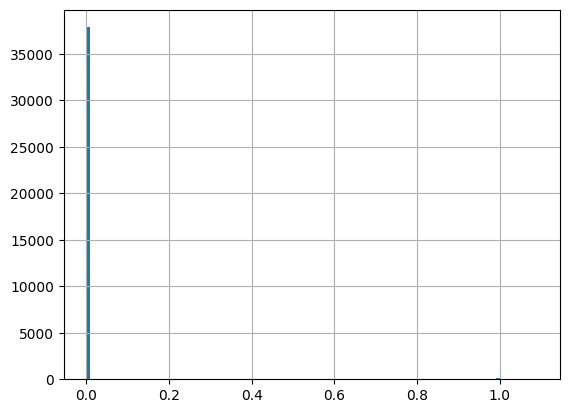

In [21]:
# 背番号の認識 確信度のヒストグラム
# 細かく分布を見るために、0.01刻みで表示
soccernetv2_states.gamestate_df["jersey_number_confidence"].hist(bins=np.arange(0, 1.1, 0.01))

<Axes: >

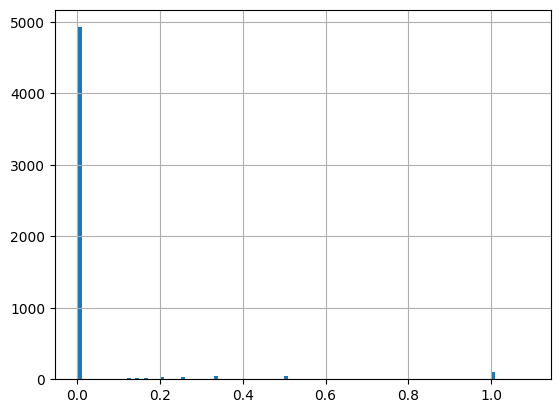

In [26]:
# 画像ごとの背番号認識割合 soccernetv2
soccernetv2_states.gamestate_df["jersey_number_detection"].notnull().groupby(soccernetv2_states.gamestate_df["image_id"]).mean().hist(bins=np.arange(0, 1.1, 0.01))

<Axes: >

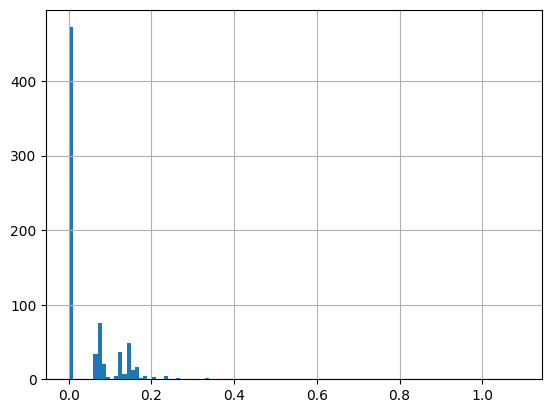

In [27]:
# 画像ごとの背番号認識割合 gsr
gsr_states.gamestate_df["jersey_number_detection"].notnull().groupby(gsr_states.gamestate_df["image_id"]).mean().hist(bins=np.arange(0, 1.1, 0.01))